In [107]:
# Jobs Data
# (TaskID, MachineID, Duration, Energy Rate(kwh))
jobs_data = {
    "Job1": [("A", 3, 2, 35), ("B", 2, 2, 20), ("C", 1, 3, 25)],
    "Job2": [("D", 1, 2, 27), ("E", 2, 2, 32), ("F", 3, 3, 37)],
    "Job3": [("G", 2, 2, 19), ("H", 3, 2, 36), ("I", 1, 3, 28)],
    "Job4": [("J", 1, 2, 26), ("K", 2, 2, 22), ("L", 3, 3, 34)],
    "Job5": [("M", 2, 2, 21), ("N", 3, 2, 35), ("O", 1, 3, 29)],
    "Job6": [("P", 3, 2, 33), ("Q", 1, 2, 27), ("R", 2, 3, 20)]
}

num_machines = 3

makespan= 15

In [108]:
import pygad
import pandas as pd
import csv
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import math

In [109]:
# Use future predicted PV power output from the predictive model 

predicted_PV_output_list = []

with open ("future_PV_power_predictions.csv", "r") as file:
    csv_reader = csv.reader(file)
    next(csv_reader) #Skip heading row
    
    for row in csv_reader:
        predicted_PV_output_list.append(float(row[1]) / 1000)
# PV generation for the date specified in the predictive model
#pv_generation = predicted_PV_output_list

pv_generation = [0, 0, 0, 0, 0, 0.656, 1.803, 6.997, 16.5747, 25.7345, 29.4745, 35.707, 38.474, 35.212, 28.547, 25.4645, 23.342, 9.8065, 5.241, 1.066, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.656, 1.803, 6.997, 16.5747, 25.7345, 29.4745, 35.707, 38.474, 35.212, 28.547, 25.4645, 23.342, 9.8065, 5.241, 1.066, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.656, 1.803, 6.997, 16.5747, 25.7345, 29.4745, 35.707, 38.474, 35.212, 28.547, 25.4645, 23.342, 9.8065, 5.241, 1.066, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.656, 1.803, 6.997, 16.5747, 25.7345, 29.4745, 35.707, 38.474, 35.212, 28.547, 25.4645, 23.342, 9.8065, 5.241, 1.066, 0, 0, 0, 0]


# Time-of-Use (TOU) electricity tariffs for a 24-hour period
tou_rates = [0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.60, 0.60, 0.40, 0.40, 0.40, 0.40, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.60, 0.60, 0.40, 0.40, 0.40, 0.40, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.60, 0.60, 0.40, 0.40, 0.40, 0.40, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.60, 0.60, 0.40, 0.40, 0.40, 0.40, 0.20]

## Chromosome Encoding
First, a list of all tasks containing the ID of every task is created. A mapping of tasks to integers and vice versa is then created. Mapping task IDs (letters) to integers is a necessity for the effective application of GA operations such as mutation and crossover. A mapping is then created of each task to its respective job for keeping track of which job each task belongs to. A dictionary with the sequence of tasks within each job is created and a list with the job indices is created. 

In [110]:
# Flatten the list of tasks and extract the unique task IDs
all_tasks = [task[0] for job in jobs_data.values() for task in job]

# Create a mapping of tasks to integers and vice versa
task_to_int = {task: i for i, task in enumerate(all_tasks)}
int_to_task = {i: task for task, i in task_to_int.items()}

# Create a mapping of each task to its job
task_to_job = {}
for job, tasks in jobs_data.items():
    for task in tasks:
        task_id = task[0]
        task_to_job[task_id] = job

# Printing out the mappings to verify
print("Task to Integer Mapping:", task_to_int)
print("Integer to Task Mapping:", int_to_task)
print("Task to Job Mapping:", task_to_job)


# Create a dictionary with the sequence of tasks within each job
job_sequences = {job_id: [task[0] for task in tasks] for job_id, tasks in jobs_data.items()}
print(f"Sequence of tasks in each job: {job_sequences}")

# Create list of job indices for easy access to jobs
job_indices = list(jobs_data.keys())

Task to Integer Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17}
Integer to Task Mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R'}
Task to Job Mapping: {'A': 'Job1', 'B': 'Job1', 'C': 'Job1', 'D': 'Job2', 'E': 'Job2', 'F': 'Job2', 'G': 'Job3', 'H': 'Job3', 'I': 'Job3', 'J': 'Job4', 'K': 'Job4', 'L': 'Job4', 'M': 'Job5', 'N': 'Job5', 'O': 'Job5', 'P': 'Job6', 'Q': 'Job6', 'R': 'Job6'}
Sequence of tasks in each job: {'Job1': ['A', 'B', 'C'], 'Job2': ['D', 'E', 'F'], 'Job3': ['G', 'H', 'I'], 'Job4': ['J', 'K', 'L'], 'Job5': ['M', 'N', 'O'], 'Job6': ['P', 'Q', 'R']}


## Generate Initial Population
This function generates a diverse and feasible set of chromosomes for the initial population that respect the job shop scheduling constraints. 

In [111]:
# Generate a diverse initial population of solutions that abide by job-shop scheduling constraints
def generate_diverse_population(sol_per_pop, job_sequences, task_to_int):
    initial_population = []
    for _ in range(sol_per_pop):
        
        # Create a copy of job_sequences that will be modified. 
        working_sequences = {job: list(seq) for job, seq in job_sequences.items()}
        solution = []
        
        # While there are tasks left to be scheduled
        while any(working_sequences.values()):
            
            # Finds jobs which still have tasks left to schedule
            available_jobs = [job for job, seq in working_sequences.items() if seq]
            
            # Select a random job from the available jobs
            chosen_job = random.choice(available_jobs)
            
            # Remove the first task from the chosen job in working sequences
            next_task = working_sequences[chosen_job].pop(0)
            
            # Convert the task ID to its integer representation before appending
            solution.append(task_to_int[next_task])
            
        initial_population.append(solution)
    return initial_population

Call the generate_diverse_population function to generate $sol\_per\_pop$ chromosomes in the initial population. 

In [112]:
# Number of solutions per population
sol_per_pop = 300 
initial_population = generate_diverse_population(sol_per_pop, job_sequences, task_to_int)

# Print the first 5 solutions to check their diversity
for i, solution in enumerate(initial_population[:5]):
    solution_task_ids = [int_to_task[num] for num in solution]
    print(f"Solution {i+1}: {solution}")
    print(f"Solution {i+1} (task IDs): {solution_task_ids}")

Solution 1: [9, 10, 11, 3, 6, 15, 16, 17, 12, 7, 0, 1, 2, 8, 13, 14, 4, 5]
Solution 1 (task IDs): ['J', 'K', 'L', 'D', 'G', 'P', 'Q', 'R', 'M', 'H', 'A', 'B', 'C', 'I', 'N', 'O', 'E', 'F']
Solution 2: [15, 3, 0, 4, 5, 9, 16, 17, 10, 6, 1, 12, 13, 14, 2, 11, 7, 8]
Solution 2 (task IDs): ['P', 'D', 'A', 'E', 'F', 'J', 'Q', 'R', 'K', 'G', 'B', 'M', 'N', 'O', 'C', 'L', 'H', 'I']
Solution 3: [6, 9, 0, 10, 7, 3, 1, 8, 4, 12, 11, 2, 13, 5, 14, 15, 16, 17]
Solution 3 (task IDs): ['G', 'J', 'A', 'K', 'H', 'D', 'B', 'I', 'E', 'M', 'L', 'C', 'N', 'F', 'O', 'P', 'Q', 'R']
Solution 4: [9, 6, 12, 10, 11, 15, 13, 7, 14, 8, 3, 4, 16, 17, 5, 0, 1, 2]
Solution 4 (task IDs): ['J', 'G', 'M', 'K', 'L', 'P', 'N', 'H', 'O', 'I', 'D', 'E', 'Q', 'R', 'F', 'A', 'B', 'C']
Solution 5: [15, 9, 6, 16, 3, 17, 4, 0, 1, 10, 2, 5, 12, 13, 7, 8, 14, 11]
Solution 5 (task IDs): ['P', 'J', 'G', 'Q', 'D', 'R', 'E', 'A', 'B', 'K', 'C', 'F', 'M', 'N', 'H', 'I', 'O', 'L']


# Crossover
In this crossover function, two parents are randomly selected from the parents pool. This pool is a subset of the current population and its size is determined by the $num\_parents\_mating$ parameter in the $ga\_instance$. Let $N_j$ be the number of jobs in the problem. A random number of jobs between 1 and $N_j - 2$ are selected from the first parent and the tasks from the selected jobs are copied into the offspring. The reason for putting an upper bound on the number of jobs selected from the first parent of $N - 2$ is to ensure that the offspring is not the same as the first parent. The offspring's remaining positions are filled with tasks from the second parent, keeping the order of these tasks as they appear in the second parent.

In [113]:
def custom_crossover(parents, offspring_size, ga_instance):
    
    # Initialise empty array to store offspring generated by the crossover function
    offspring = np.empty(offspring_size, dtype=object)

    for idx, parent in enumerate(parents):
        
        # Convert integers to task IDs
        parent_task_ids = [int_to_task[gene] for gene in parent]  
        
    for k in range(offspring_size[0]):
        # Select two parents from the parents pool. Size of the pool is determined by num_parents_mating in the ga instance
        parent1_idx, parent2_idx = np.random.choice(range(len(parents)), 2, replace=False)
        parent1, parent2 = parents[parent1_idx].tolist(), parents[parent2_idx].tolist()

    
        # Random number of jobs to select
        selected_jobs_count = random.randint(1, len(jobs_data)-2)
        
        # Randomly select jobs from Parent 1
        selected_jobs = random.sample(job_indices, k=selected_jobs_count)
        
        # Initialise offspring
        offspring_tasks = [None] * len(parent1)  

        # Place tasks from selected jobs of Parent 1 into offspring
        for job in selected_jobs:
            for task in jobs_data[job]:
                task_idx = parent1.index(task_to_int[task[0]])
                offspring_tasks[task_idx] = task_to_int[task[0]]

        # Fill in gaps with tasks from Parent 2
        for task in parent2:
            if task not in offspring_tasks:
                next_idx = offspring_tasks.index(None)
                offspring_tasks[next_idx] = task

        offspring[k] = offspring_tasks

    return np.array(offspring, dtype=np.int32)

## Mutation
An adaptive mutation approach is used. Adaptive mutation alters the mutation rate based on the fitness of an individual chromosome. The average fitness of the current population is first calculated. Any chromosomes with a below average fitness are assigned a higher mutation rate to increase their chance of evolving into better solutions. Chromosomes with an above average fitness have a lower mutation rate so that they are not disrupted by mutation. For the mutation process, two jobs are selected randomly from the set of all jobs. The tasks within these jobs are then identified and swapped. This is done a predetermined number of times depending on the fitness of the solution relative to the average fitness of the current population.

In [114]:
def average_population_fitness(ga_instance):
    # Get the current population
    current_population = ga_instance.population

    # Placeholder for fitness values
    fitness_values = np.zeros(ga_instance.sol_per_pop)

    # Calculate fitness for each individual in the population
    for idx, individual in enumerate(current_population):
        fitness_values[idx] = ga_instance.fitness_func(ga_instance, individual, idx)

    # Calculate the average fitness of the population
    average_fitness = np.mean(fitness_values)
    print(f"Average fitness: {average_fitness}")

    return average_fitness

In [115]:
def custom_adaptive_mutation(offspring, ga_instance):
    # Calculate the average fitness of the current population
    average_fitness = average_population_fitness(ga_instance)
    
    # Total number of jobs in the problem
    num_jobs = len(jobs_data)         
        
    # Go through each individual in the offspring for mutation
    for idx, individual in enumerate(offspring):

        # Extract the individual fitness from the fitness values calculated before mutation
        individual_fitness = ga_instance.last_generation_fitness[idx]
        
        # Dynamically adjust the mutation rate
        if individual_fitness < average_fitness:
            # Higher mutation rate for below-average individuals
            mutation_rate = 0.4  
            # Higher number of swaps for below-avearge individuals
            num_swaps = random.randint(num_jobs // 2, num_jobs)
        else:
            # Lower mutation rate for above-average individuals
            mutation_rate = 0.3 
            # Lower number of swaps for above-average individuals
            num_swaps = random.randint(1, num_jobs // 2)

        # Perform mutation based on the mutation rate
        if np.random.rand() <= mutation_rate:
            # Convert the numpy array to a list for easy manipulation
            individual_list = individual.tolist() if isinstance(individual, np.ndarray) else individual
            
            # Convert solution integers back to task IDs
            task_ids_solution = [int_to_task[i] for i in individual_list]
            
            # Extract job sequences
            job_sequences = [job for job in jobs_data.values()]

            for _ in range(num_swaps):
                # Choose two distinct jobs randomly
                job_indices = random.sample(range(len(job_sequences)), 2)
                job1_idx, job2_idx = job_indices[0], job_indices[1]
                job1, job2 = job_sequences[job1_idx], job_sequences[job2_idx]

                # Make sure both jobs have the same number of tasks or adjust
                min_length = min(len(job1), len(job2))
                
                # Swap the positions of corresponding tasks from the two jobs
                for i in range(min_length):  
                    task1 = job1[i][0]
                    task2 = job2[i][0]
                    if task1 in task_ids_solution and task2 in task_ids_solution:
                        task1_idx = task_ids_solution.index(task1)
                        task2_idx = task_ids_solution.index(task2)
                        task_ids_solution[task1_idx], task_ids_solution[task2_idx] = task2, task1

            # Convert task IDs back to integer representation
            mutated_solution = [task_to_int[task_id] for task_id in task_ids_solution]
            
            # Update the individual in the offspring
            offspring[idx] = np.array(mutated_solution) if isinstance(individual, np.ndarray) else mutated_solution
        
    return offspring

## Task timings, PV power and grid power
The below helper function is used in the fitness function to compute the start
and end times of each solution as well as the hourly PV power and grid power used in the solution. Each task in the solution is given a time window whos length is proportional to its energy consumption to explore possible start times. The start time with the lowest electricity rate is chosen.  

In [116]:
def calculate_task_timings_and_power(solution, jobs_data, pv_generation, tou_rates):
    # Initialise list for machine next available time
    machine_next_available_time = [0] * num_machines
    
    # Initialise dictionary to track the end time of the last task for each job in the schedule.
    # This gets updated as more tasks are assigned start and end times
    job_last_task_end_time = {job: 0 for job in jobs_data}
    
    # Initialise list for the task timings. Will include (Task ID, Machine ID, Task start time, Task end time)
    task_timings = []
    
    # Define the solution to be valid for now
    valid_solution = True
    
    # Define the makespan of the solution to be 0 for now
    max_end_time = 0
    
    # Define the base exploration window for finding cheapest start times
    base_exploration_window = 0
    
    # Create list of energy rates of all tasks
    energy_rates = [task[3] for job in jobs_data.values() for task in job]
    
    # Find the minimum energy rate
    min_energy_rate = min(energy_rates)
    
    # Find the maximum energy rate
    max_energy_rate = max(energy_rates)

    # Initialise list for the PV power and grid power utilised per hour
    # Set both to 0 for now and will be updated as tasks are assigned starting times
    pv_utilised_per_hour = [0] * makespan
    grid_power_needed_per_hour = [0] * makespan

    for index, task_int in enumerate(solution):
        task_id = int_to_task[task_int]
        job = task_to_job[task_id]
        task_details = next((task for task in jobs_data[job] if task[0] == task_id), None)

        if not task_details:
            valid_solution = False
            break

        _, machine_id, duration, energy_rate = task_details
        
        # Adjust to 0-based indexing
        machine_id -= 1  
        
        # Normalise the energy rate for the current task
        # Prevent division by zero
        if max_energy_rate != min_energy_rate:  
            normalized_energy_rate = (energy_rate - min_energy_rate) / (max_energy_rate - min_energy_rate)
        else:
            # If all tasks have the same energy rate, treat them equally
            normalized_energy_rate = 1  

        # Find the earliest and best start time considering constraints
        earliest_start_time = max(machine_next_available_time[machine_id], job_last_task_end_time[job])
        best_start_time, best_cost = None, float('inf')
        dynamic_exploration_window = base_exploration_window * normalized_energy_rate
        latest_start_time = round(earliest_start_time + dynamic_exploration_window)
        
        # Evaluate the best start time for the task, within the allowable window
        for potential_start_time in range(earliest_start_time, latest_start_time):
            cost = 0
            
            # Iterate over all the hours from a potential start time to find the cost of that start time
            for h in range(duration):
                hour = (potential_start_time + h) % makespan
                energy_needed = energy_rate
                pv_available_this_hour = max(0, pv_generation[hour] - pv_utilised_per_hour[hour])
                grid_energy_needed = max(0, energy_needed - pv_available_this_hour)
                cost += grid_energy_needed * tou_rates[hour]
                
            if cost < best_cost:
                best_cost = cost
                best_start_time = potential_start_time
                
        # Start time is the best start time if there is one, else set to earliest start time
        start_time_to_use = best_start_time if best_start_time is not None else earliest_start_time
        
        # Update PV and grid power utilisation
        for h in range(duration):
            hour = (start_time_to_use + h) % makespan
            energy_needed = energy_rate
            pv_available_this_hour = max(0, pv_generation[hour] - pv_utilised_per_hour[hour])
            
            # Add up the PV utilised for this hour
            pv_utilised_this_hour = min(energy_needed, pv_available_this_hour)
            pv_utilised_per_hour[hour] += pv_utilised_this_hour
            
            # Add up the grid energy used in this hour
            grid_energy_needed = max(0, energy_needed - pv_utilised_this_hour)
            grid_power_needed_per_hour[hour] += grid_energy_needed
            
        # Append to the task timings list (task ID, machine ID, start time, end time)   
        task_timings.append((task_id, machine_id + 1, start_time_to_use, start_time_to_use + duration))
        
        # Finds the makespan of the solution after all the tasks have been iterated through
        max_end_time = max(max_end_time, start_time_to_use + duration)
        
        # Update the machine next available time
        machine_next_available_time[machine_id] = start_time_to_use + duration
        
        # Update the end time of the last task in the job
        job_last_task_end_time[job] = start_time_to_use + duration

    return task_timings, valid_solution, max_end_time, grid_power_needed_per_hour, pv_utilised_per_hour


## Fitness function
The fitness function evaluates solutions based on their total electricity costs, incorporating penalties for chedules that exceed
the predefined makespan.

In [117]:
def fitness_func(ga_instance, solution, solution_idx):
    task_timings, valid_solution, max_end_time, grid_power_needed_per_hour, pv_utilised_per_hour = calculate_task_timings_and_power(solution, jobs_data, pv_generation, tou_rates)

    # Set fitness of invalid solutions to 0
    if not valid_solution:
        return 0  
    
    # Calculate the total electricity cost for the solution
    total_cost = sum(grid_power_needed * rate for grid_power_needed, rate in zip(grid_power_needed_per_hour, tou_rates))

    # Apply a penalty or adjustment factor for solutions with makespans greater than the makespan limit
    # This creates a gradient where solutions closer to makespan are preferred
    if max_end_time > makespan:
        # Linear penalty: increase total cost based on the excess hours
        excess_hours = max_end_time - makespan
        penalty_cost = 300 * excess_hours  
        adjusted_cost = total_cost + penalty_cost
    else:
        adjusted_cost = total_cost

    # Calculate fitness, solutions with lower costs have higher fitness
    fitness = 1.0 / adjusted_cost if adjusted_cost > 0 else float('inf')  
    return fitness



In [118]:
# Function to convert population from integers to task IDs
def population_to_task_ids(population, int_to_task):
    population_task_ids = []
    for individual in population:
        individual_task_ids = [int_to_task[gene] for gene in individual]
        population_task_ids.append(individual_task_ids)
    return population_task_ids

# Define your callback function.
def on_generation(ga_instance):
    generation = ga_instance.generations_completed
    best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()
    _, _, max_end_time, _, _ = calculate_task_timings_and_power(best_solution, jobs_data, pv_generation, tou_rates)
    print(f"Generation {generation}: Best Solution Fitness = {best_solution_fitness}, Makespan of best solution: {max_end_time}")
    current_population = ga_instance.population
    current_population_task_ids = population_to_task_ids(current_population, int_to_task)

initial_population_array = np.array(initial_population, dtype=int)
    
ga_instance = pygad.GA(num_generations=500,
                       num_parents_mating=280, #Number of solutions in the pool for the crossover function to pick two parents from
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       initial_population=initial_population_array,
                       num_genes=len(task_to_int),
                       gene_space=list(range(len(task_to_int))),
                       mutation_type=custom_adaptive_mutation,  
                       K_tournament=3,
                       parent_selection_type="tournament",
                       crossover_type=custom_crossover,
                       keep_parents=1,
                       keep_elitism=1,
                       on_generation=on_generation,
                      )

    
start_time = time.time()

ga_instance.run()

end_time = time.time()

duration = end_time - start_time


    
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Final Best Solution (sequence of tasks):", [int_to_task[i] for i in solution])
print("Final Best Solution Fitness:", solution_fitness)

C:\Users\seanc\anaconda3\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Average fitness: 0.0004922239731157529
Generation 1: Best Solution Fitness = 0.0038998621476728046, Makespan of best solution: 15
Average fitness: 0.0006174552058603229
Generation 2: Best Solution Fitness = 0.003948852566114453, Makespan of best solution: 15
Average fitness: 0.0007378861000548063
Generation 3: Best Solution Fitness = 0.003974257620599245, Makespan of best solution: 15
Average fitness: 0.0007986785648551679
Generation 4: Best Solution Fitness = 0.003974257620599245, Makespan of best solution: 15
Average fitness: 0.0009478555830974973
Generation 5: Best Solution Fitness = 0.003974257620599245, Makespan of best solution: 15
Average fitness: 0.0009725086569313479
Generation 6: Best Solution Fitness = 0.003974257620599245, Makespan of best solution: 15
Average fitness: 0.001118358180241291
Generation 7: Best Solution Fitness = 0.0039901153670036296, Makespan of best solution: 15
Average fitness: 0.0014300152070920347
Generation 8: Best Solution Fitness = 0.00399011536700362

Generation 64: Best Solution Fitness = 0.003996493955782471, Makespan of best solution: 15
Average fitness: 0.0025794670136909453
Generation 65: Best Solution Fitness = 0.003996493955782471, Makespan of best solution: 15
Average fitness: 0.002788285067905452
Generation 66: Best Solution Fitness = 0.003996493955782471, Makespan of best solution: 15
Average fitness: 0.0026724729668355235
Generation 67: Best Solution Fitness = 0.003996493955782471, Makespan of best solution: 15
Average fitness: 0.0026669600256929017
Generation 68: Best Solution Fitness = 0.003996493955782471, Makespan of best solution: 15
Average fitness: 0.0025128856539120333
Generation 69: Best Solution Fitness = 0.003996493955782471, Makespan of best solution: 15
Average fitness: 0.0025043328913139226
Generation 70: Best Solution Fitness = 0.003996493955782471, Makespan of best solution: 15
Average fitness: 0.0025977553779226383
Generation 71: Best Solution Fitness = 0.003996493955782471, Makespan of best solution: 15


Average fitness: 0.002939154690720891
Generation 129: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0029937172985426324
Generation 130: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.002946796983676173
Generation 131: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.002746996687890833
Generation 132: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0028546147114514872
Generation 133: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.002820909287249791
Generation 134: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.003086270793646533
Generation 135: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0029209150013814345
Generation 136: Best Solution Fitness = 0.0040028

Generation 193: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.002987822049381683
Generation 194: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0029382451850457057
Generation 195: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0030194291450810185
Generation 196: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0029836332013004727
Generation 197: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.003091363286607018
Generation 198: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.00307551633509607
Generation 199: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0031480527098585605
Generation 200: Best Solution Fitness = 0.004002892970807862, Makespan of best solution

Average fitness: 0.002855400927789218
Generation 257: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.00275550657308133
Generation 258: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0028938773704049
Generation 259: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0029049250840908736
Generation 260: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0027890261868282534
Generation 261: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0026380879050288708
Generation 262: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0029683406351176645
Generation 263: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.002973484693608419
Generation 264: Best Solution Fitness = 0.004002892

Generation 320: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0028370065627914974
Generation 321: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.003009488099417301
Generation 322: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.002823454646275668
Generation 323: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0027786945653714913
Generation 324: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.00249023955821597
Generation 325: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.002657427988303447
Generation 326: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.002738918093286041
Generation 327: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 

Average fitness: 0.002902933082873374
Generation 384: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.003052234258933322
Generation 385: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.002802093290687951
Generation 386: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.00285766866225825
Generation 387: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0030082998511549654
Generation 388: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0027696656570557385
Generation 389: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0028330102183412955
Generation 390: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0028249033221928815
Generation 391: Best Solution Fitness = 0.0040028

Generation 447: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0028703072328103356
Generation 448: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.00273236268530806
Generation 449: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.002771507742179682
Generation 450: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0026291869248024993
Generation 451: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0027029726708283864
Generation 452: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.002918106557676324
Generation 453: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 15
Average fitness: 0.0026665871062281
Generation 454: Best Solution Fitness = 0.004002892970807862, Makespan of best solution: 1

In [126]:
# Calculate the task timings for the final solution
task_timings, valid_solution, max_end_time, grid_power_needed_per_hour, pv_utilised_per_hour = calculate_task_timings_and_power(solution, jobs_data, pv_generation, tou_rates)
print(f"Final Solution (Integers): {solution}")
solution_task_ids = [int_to_task[task_int] for task_int in solution]
print("Final Solution in Task IDs:", solution_task_ids)

# task ID, machine ID, start time, end time
print(f"Task timings are: {task_timings}")

Final Solution (Integers): [12.  3.  0. 13.  4.  9.  1.  5. 14. 10.  2.  6. 15.  7. 16.  8. 17. 11.]
Final Solution in Task IDs: ['M', 'D', 'A', 'N', 'E', 'J', 'B', 'F', 'O', 'K', 'C', 'G', 'P', 'H', 'Q', 'I', 'R', 'L']
Task timings are: [('M', 2, 0, 2), ('D', 1, 0, 2), ('A', 3, 0, 2), ('N', 3, 2, 4), ('E', 2, 2, 4), ('J', 1, 2, 4), ('B', 2, 4, 6), ('F', 3, 4, 7), ('O', 1, 4, 7), ('K', 2, 6, 8), ('C', 1, 7, 10), ('G', 2, 8, 10), ('P', 3, 7, 9), ('H', 3, 10, 12), ('Q', 1, 10, 12), ('I', 1, 12, 15), ('R', 2, 12, 15), ('L', 3, 12, 15)]


In [127]:
if valid_solution:
    # Recalculate the total electricity cost for the solution directly
    total_electricity_costs = sum(grid_power_needed * rate for grid_power_needed, rate in zip(grid_power_needed_per_hour, tou_rates))

    print(f"Total Electricity Costs: €{total_electricity_costs}")
else:
    print("Invalid solution or fitness function returned 0.")
    
final_solution_fitness = solution_fitness
print(f"Final solution fitness is: {final_solution_fitness}")
print(f"Genetic Algorithm took {duration} seconds to solve the problem.")

Total Electricity Costs: €249.81932000000003
Final solution fitness is: 0.004002892970807862
Genetic Algorithm took 45.83204436302185 seconds to solve the problem.


## Visualising the final schedule

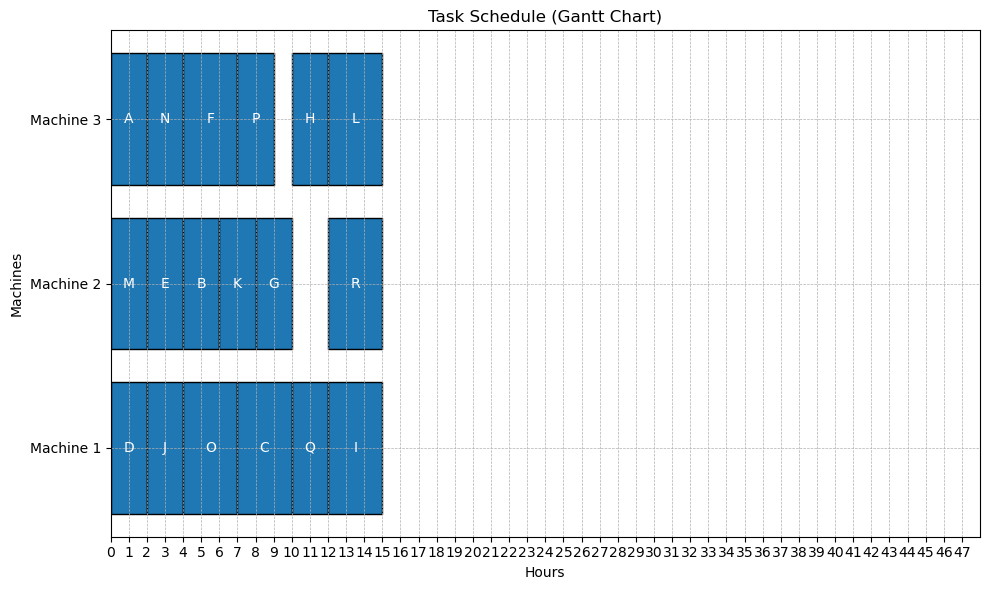

In [128]:

machine_next_available_time = {i+1: 0 for i in range(num_machines)} 
# Visualisation with Gantt Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Assign each machine a row on the chart
machine_rows = {machine_id: index + 1 for index, machine_id in enumerate(sorted(machine_next_available_time.keys()))}
for task_id, machine_id, start_time, end_time in task_timings:  
    ax.broken_barh([(start_time, end_time - start_time)], (machine_rows[machine_id] - 0.4, 0.8),
                   facecolors=('tab:blue'), edgecolor='black', label=task_id)
    ax.text((start_time + end_time) / 2, machine_rows[machine_id], task_id, ha='center', va='center', color='white')

# Setting the y-axis with machine labels
ax.set_yticks([machine_rows[machine_id] for machine_id in sorted(machine_rows.keys())])
ax.set_yticklabels([f'Machine {machine_id}' for machine_id in sorted(machine_rows.keys())])

# Formatting the x-axis to show time units clearly
plt.xlabel('Hours')
plt.ylabel('Machines')
plt.title('Task Schedule (Gantt Chart)')
ax.set_xticks(range(0, 48))  # This sets ticks from 0 to 24
ax.set_xticklabels(range(0, 48))  # This sets tick labels from 0 to 24
ax.set_xlim(0, 48)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

## PV power used in final schedule

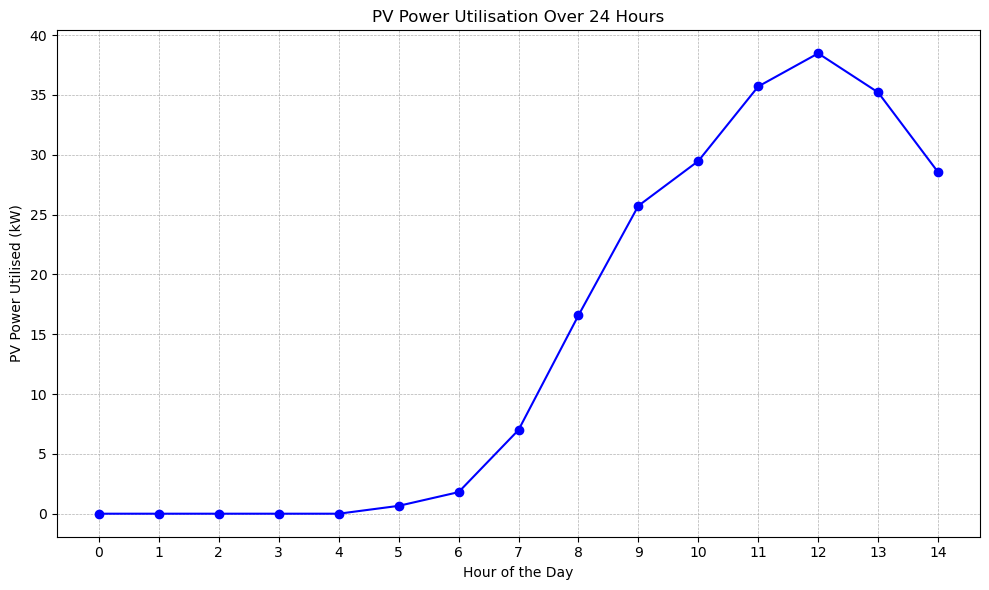

In [129]:
# Plotting the PV power used throughout the 24 hour period

plt.figure(figsize=(10, 6))
plt.plot(range(makespan), pv_power_utilised, marker='o', linestyle='-', color='blue')
plt.title('PV Power Utilisation Over 24 Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('PV Power Utilised (kW)')
plt.xticks(range(0, makespan))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Dataframe with the hour, energy from the grid, energy from the PV systems and the total energy from the grid + PV system

In [123]:
# First, create a list to hold the row data for the DataFrame
data_for_df = []

# Populate the data_for_df list with the required data
for hour in range(makespan):
    
    # Get the energy from grid for that hour
    energy_from_grid = grid_power_needed[hour]
    
    # Get the energy from PV for that hour
    energy_from_pv = pv_power_utilised[hour]
    
    TOU_rate = tou_rates[hour]
    
    # Calculate the total energy from grid + PV
    total_energy = energy_from_grid + energy_from_pv
    
    # Append the row to the list
    data_for_df.append({
        "Hour": hour,
        "Energy from Grid (kW)": energy_from_grid,
        "Energy from PV (kW)": energy_from_pv,
        "Total Energy (Grid+PV) (kW)": total_energy,
        "TOU rate": TOU_rate
    })

# Create the DataFrame
final_solution_df = pd.DataFrame(data_for_df).set_index('Hour')

# Display the DataFrame
final_solution_df


,Energy from Grid (kW),Energy from PV (kW),Total Energy (Grid+PV) (kW),TOU rate
Hour,,,,
0,83.0000,0.0000,83.0,0.2
1,83.0000,0.0000,83.0,0.2
2,93.0000,0.0000,93.0,0.2
3,93.0000,0.0000,93.0,0.2
4,86.0000,0.0000,86.0,0.2
5,85.3440,0.6560,86.0,0.2
6,86.1970,1.8030,88.0,0.2
7,73.0030,6.9970,80.0,0.2
8,60.4253,16.5747,77.0,0.4
